# Import and settings
To run this notebook, install R and muRty and set up a PATH to Rscript.exe.

In [1]:
import os
import sys

from lingd import LiNGD

import numpy as np

import graphviz
import matplotlib
import matplotlib.pyplot as plt
from lingam.utils import make_dot
from IPython.display import display, Markdown

np.set_printoptions(precision=3, suppress=True)
print([np.__version__, matplotlib.__version__, graphviz.__version__])

np.random.seed(100)

['1.24.4', '3.7.4', '0.20.1']


# Test data
Test data is generated by this adjacency matrix.

## Causal graph

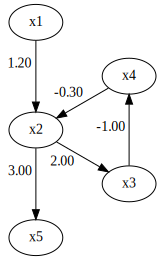

In [2]:
B = np.array([
    [ 0.0, 0.0, 0.0, 0.0, 0.0,],
    [ 1.2, 0.0, 0.0,-0.3, 0.0,],
    [ 0.0, 2.0, 0.0, 0.0, 0.0,],
    [ 0.0, 0.0,-1.0, 0.0, 0.0,],
    [ 0.0, 3.0, 0.0, 0.0, 0.0,],
])

def display_graph(B, scale=1.5, lower_limit=0.2):
    dot = make_dot(B, labels=[f"x{i+1}" for i in range(B.shape[1])], lower_limit=lower_limit)
    
    s = dot.source
    s = s.replace("\tx1\n", f"\tx1 [pos=\"0,0!\"]\n")
    s = s.replace("\tx2\n", f"\tx2 [pos=\"0,{-1*scale}!\"]\n")
    s = s.replace("\tx3\n", f"\tx3 [pos=\"{0.5*3**0.5*scale},{-1.5*scale}!\"]\n")
    s = s.replace("\tx4\n", f"\tx4 [pos=\"{0.5*3**0.5*scale},{-0.5*scale}!\"]\n")
    s = s.replace("\tx5\n", f"\tx5 [pos=\"0,{-2*scale}!\"]\n")

    display(graphviz.Source(s, engine="neato"))

display_graph(B)

## Generating data

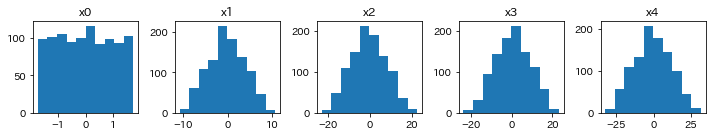

In [3]:
sample_size = 1000

# error variables
es = []
for i in range(len(B)):
    es.append(np.random.uniform(-1 * (3 ** 0.5), 3 ** 0.5, size=sample_size))
es = np.array(es).T

# X = Ae
A = np.linalg.inv(np.eye(len(B)) - B)
X = (A @ es.T).T

fig, axes = plt.subplots(1, len(B), figsize=(2 * len(B), 2))
for i, x in enumerate(X.T):
    axes[i].hist(x)
    axes[i].set_title(f"x{i}")
plt.tight_layout()
plt.show()

# Estimating causal graph

## Fit

In [4]:
model = LiNGD(k=3)
model.fit(X)

## Results

### Result 0
- cost = 4.92
- Stable = True

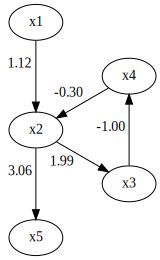

### Result 1
- cost = 6.67
- Stable = False

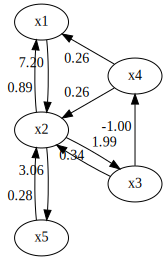

### Result 2
- cost = 10.97
- Stable = False

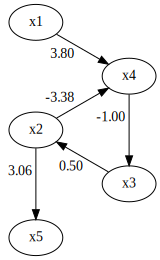

In [5]:
zipped = zip(model.adjacency_matrices_, model.costs_, model.is_stables_)

for i, (adj, cost, is_stable) in enumerate(zipped):
    display(Markdown(f"### Result {i}\n- cost = {cost:.2f}\n- Stable = {is_stable}"))
    display_graph(adj)

To display only stable results, execute the following code.

### Result 0
- cost = 4.92


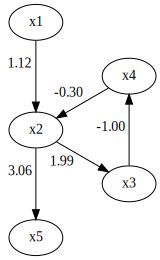

In [6]:
# filter properties with is_stables_
zipped = zip(
    # index of stable results
    np.arange(len(model.is_stables_))[model.is_stables_],
    
    # filtered adjacency_matrices_
    model.adjacency_matrices_[model.is_stables_],
    
    # filtered costs_
    model.costs_[model.is_stables_],
)

for i, adj, cost in zipped:
    display(Markdown(f"### Result {i}\n- cost = {cost:.2f}\n"))
    display_graph(adj)

# Estimating effects of causal effect

estimates_causal_effects(target_index) calculates the difference between an intervention with 1 and an intervention with 0 in the target_index variable.

In [7]:
# the intervention target is x2.
effects = model.estimates_causal_effects(1)

x2 is 1 for all results because it is the target of intervention. x2 affects x3, x4 and x5. 

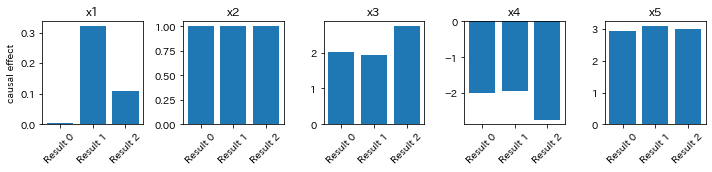

In [8]:
fi, axes = plt.subplots(1, len(effects.T), figsize=(2 * len(effects.T), 2.5))
for i, effect in enumerate(effects.T):
    xticks = np.arange(len(effect))
    axes[i].bar(xticks, effect)
    axes[i].set_xticks(xticks)
    axes[i].set_xticklabels([f"Result {x}" for x in xticks], rotation=45)
    if i == 0:
        axes[i].set_ylabel("causal effect")
    axes[i].set_title(f"x{i + 1}")
plt.tight_layout()
plt.show()

# Limitation

LiNGD estimates only one result when the number of variables is two because of a limitation of muRty package.

In [9]:
# generating data
B = np.array([
    [ 0.0, 0.5],
    [ 0.5, 0.0],
])

es = []
for i in range(len(B)):
    es.append(np.random.uniform(-1 * (3 ** 0.5), 3 ** 0.5, size=sample_size))
es = np.array(es).T

A = np.linalg.inv(np.eye(len(B)) - B)
X = (A @ es.T).T

# estimation
model = LiNGD(k=2)
model.fit(X)

# the length is 1, not 2
len(model.adjacency_matrices_)

1